# Imports

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import RandomOverSampler


pd.set_option('display.float_format', lambda x: '%.2f' % x)
RSEED = 42

# Import Data

In [3]:
invoice_train = pd.read_csv('data/train/invoice_train.csv')
client_train = pd.read_csv('data/train/client_train.csv')


/var/folders/9x/vhdwn1fd0cldzwf9fnftwf980000gn/T/ipykernel_38057/3220789026.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  invoice_train = pd.read_csv('data/train/invoice_train.csv')


## EDA


### Drop Outliers

In [ ]:
# Drop outliers high month
invoice_train= invoice_train[invoice_train['months_number']<=36]

### Calculate Over Rows

In [20]:
# Transactions Counts
transaction_counts_df = invoice_train.groupby('client_id').size().reset_index(name='transactions_count'.format('1'))
client_train.merge(transaction_counts_df, how='left', on='client_id')

,disrict,client_id,client_catg,region,creation_date,target,transactions_count
0,60,train_Client_0,11,101,31/12/1994,0.00,35
1,69,train_Client_1,11,107,29/05/2002,0.00,37
2,62,train_Client_10,11,301,13/03/1986,0.00,18
3,69,train_Client_100,11,105,11/07/1996,0.00,20
4,62,train_Client_1000,11,303,14/10/2014,0.00,14
...,...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,26/07/2004,0.00,71
135489,63,train_Client_99996,11,311,25/10/2012,0.00,41
135490,63,train_Client_99997,11,311,22/11/2011,0.00,36
135491,60,train_Client_99998,11,101,22/12/1993,0.00,2


In [48]:
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [61]:
# Cosummation per Time  

invoice_train['invoice_date'] = pd.to_datetime(invoice_train['invoice_date'])
# Calculate the Consumption Amount:
invoice_train['consommation_amount'] = invoice_train['consommation_level_1'] + invoice_train['consommation_level_2'] + invoice_train['consommation_level_3'] + invoice_train['consommation_level_4']
# Calculate the Time Period Between Invoices:
invoice_train = invoice_train.sort_values(by=['client_id', 'counter_type', 'invoice_date'])
invoice_train['invoice_period'] = invoice_train.groupby(['client_id', 'counter_type'])['invoice_date'].diff()



In [67]:
def replaceNAT(x):
    if x['invoice_period'].isna:
        return x['months_number'] * 30
    else:
        return x['invoice_period']


invoice_train['invoice_period'] = invoice_train.apply(replaceNAT, axis=1)

AttributeError: 'NaTType' object has no attribute 'isna'

In [65]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,consommation_amount,invoice_period
22,train_Client_0,2005-10-17,11,1335667,0,203,6,1,124,0,0,0,3685,3809,4,ELEC,124,NaT
23,train_Client_0,2006-02-24,11,1335667,0,203,6,1,141,0,0,0,3809,3950,4,ELEC,141,130 days
24,train_Client_0,2006-06-23,11,1335667,0,203,6,1,162,0,0,0,3950,4112,4,ELEC,162,119 days
25,train_Client_0,2006-10-18,11,1335667,0,203,6,1,159,0,0,0,4112,4271,4,ELEC,159,117 days
28,train_Client_0,2007-02-26,11,1335667,0,203,6,1,182,0,0,0,4271,4453,4,ELEC,182,131 days


In [ ]:
# most frequent reading_remarque (Maria)

In [ ]:
# mean counter_coefficient (Maria)

In [ ]:
# mean month_numbers by client (Jesus)


In [ ]:
# encode counter_type
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)

Columns which we can't aggregate to one single client:
- invoice_date
- tarif
- counter_number
- counter_statue
- counter_code

In [ ]:
# Check how many values, if we could aggregate specific features to one single client
# grouped = invoice_train.groupby('client_id')
# test = grouped['counter_type'].nunique()
# test.unique()
# counter_counts_df = invoice_train.groupby('client_id').size().reset_index(name='transactions_count'.format('1'))


array([1, 2])

### Calculate over Columns

In [ ]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

# extract day, month, year, dayofweek
invoice_train['day'] = invoice_train['invoice_date'].dt.day
invoice_train['month'] = invoice_train['invoice_date'].dt.month
invoice_train['year'] = invoice_train['invoice_date'].dt.year
invoice_train['day_of_week'] = invoice_train['invoice_date'].dt.dayofweek

invoice_train['weekend'] = np.where(invoice_train['day_of_week'].isin([6]), 1,0)

invoice_train['weekend'].value_counts()

In [ ]:
# Delete GAZ/ELEC

# Train-Test-Split

In [9]:
y= client_train['target']
X = client_train.drop('target', axis = 1)

In [12]:
# test train split only with client-data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED, stratify=y)

In [ ]:
# handling the imbalanced
ros = RandomOverSampler(random_state=RSEED)
X_train, y_train = ros.fit_resample(X_train, y_train)

<Axes: xlabel='target', ylabel='count'>

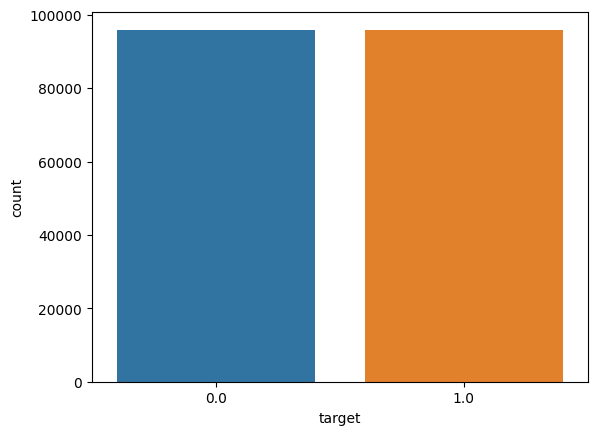

In [16]:
sns.countplot(x=y_train)

In [4]:
merged_df = client_train.merge(invoice_train, how= "left", on='client_id')
merged_df.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,60,train_Client_0,11,101,31/12/1994,0.00,2014-03-24,11,1335667,0,...,8,1,82,0,0,0,14302,14384,4,ELEC
1,60,train_Client_0,11,101,31/12/1994,0.00,2013-03-29,11,1335667,0,...,6,1,1200,184,0,0,12294,13678,4,ELEC
2,60,train_Client_0,11,101,31/12/1994,0.00,2015-03-23,11,1335667,0,...,8,1,123,0,0,0,14624,14747,4,ELEC
3,60,train_Client_0,11,101,31/12/1994,0.00,2015-07-13,11,1335667,0,...,8,1,102,0,0,0,14747,14849,4,ELEC
4,60,train_Client_0,11,101,31/12/1994,0.00,2016-11-17,11,1335667,0,...,9,1,572,0,0,0,15066,15638,12,ELEC
